# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Наша задача:**
1.	Загрузить и подготовить данные.
2.	Обучить разные модели. Для каждой попробуйте различные гиперпараметры.
3.	Проанализировать скорость работы и качество моделей.
*Примечания:*
-	Для оценки качества моделей применяйте метрику RMSE.
-	Используйте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
-	Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

**Наш план:**
1.	Загрузим и подготовим данные.
2.	Обучим разные модели. Для каждой попробуем различные гиперпараметры.
3.	Проанализируем скорость работы и качество моделей.

**Описание данных:**
Данные находятся в файле /datasets/autos.csv.

**Признаки:**
-	DateCrawled — дата скачивания анкеты из базы
-	VehicleType — тип автомобильного кузова
-	RegistrationYear — год регистрации автомобиля
-	Gearbox — тип коробки передач
-	Power — мощность (л. с.)
-	Model — модель автомобиля
-	Kilometer — пробег (км)
-	RegistrationMonth — месяц регистрации автомобиля
-	FuelType — тип топлива
-	Brand — марка автомобиля
-	NotRepaired — была машина в ремонте или нет
-	DateCreated — дата создания анкеты
-	NumberOfPictures — количество фотографий автомобиля
-	PostalCode — почтовый индекс владельца анкеты (пользователя)
-	LastSeen — дата последней активности пользователя

**Целевой признак:**
-   Price — цена (евро)

In [1]:
# ячейка для импорта библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from time import time

## Подготовка данных

In [2]:
# скачиваем и открываем файл
try:
    autos = pd.read_csv(r'/datasets/autos.csv')
except:
    autos = pd.read_csv(r'https://code.s3.yandex.net/datasets/autos.csv')

display(autos.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


На первый взгляд мы имеем: 
- DateCrawled (дата скачивания анкеты из базы), 
- DateCreated (дата создания анктеты), 
- LastSeen (дата последней активности пользователя) в виде даты, но непонятно как она записана - датой или же строкой. 
- VehicleType (тип кузова) - строка, но есть пропуски - непонятно сколько их. RegistrationYear (год регистрации автомобиля) - в виде целого числа. Предварительно - в этом столбце пропусков не будет. 
- Gearbox (тип коробки передач) - строка (ручная коробка или же автомат). 
- Ситуация со столбцами Power (мощность двигателя) и Kilometer (пробег в км) аналогична ситуации в столбце RegistrationYear - целые числа и скорее всего пропусков не будет. 
- RegistrationMonth - похоже был снят с даты и преобразован по типу Ordinal Encoding. 
- В столбце FuelType (тип топлива) (записаного строкой) точно есть пропуски, но не ясно сколько их. 
- Со столбцом Repaired (была машина в ремонте или нет) - ситуация аналогична столбцу FuelType. 
- Brand (марка машины) - строка, но не ясно есть ли пропуски.  
- Столбец NumberOfPictures - целое число, скорее всего пропусков нет. 
- PostalCode - целое число, скорее всего пропусков нет, но связь с ценой вообще не ясна - скорее это просто для связи с владельцем.

In [3]:
# выводим информацию о нашем датафрейме
print(autos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Неожиданностей не много - в столбах, где было целое число пропусков не оказалось - это верно. Пропуски есть в столбце VehicleType - примерно 37.5 тысяч пропусков. В столбце Gearbox - немногим менее 20 тыс. пропусков. FuelType - примерно 33 тысячи пропусков. В столбце Repaired - немногим более 71 тысячи пропусков. Для выборки в 354 тысячи строк - это большие пропуски - надо заполять. Во всех столбцах с датой записаны строки, а не дата.

In [4]:
# проверка на явные дубликаты
print(autos.duplicated().sum())

4


Есть совсем немного явных дубликатов - надо удалять.

In [5]:
# удаляем явные дубликаты и снова проверяем на их наличие (проверка удаления)
autos.drop_duplicates(inplace=True, ignore_index=True)
print(autos.duplicated().sum())

0


Явные дубликаты удалены. Теперь приведёе стрки с датой к дате, а далее нужно думать как заполнить пропуски в данных.

In [6]:
# приводим столбцы к типу дата-время
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'], format='%Y-%m-%d %H:%M:%S')
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'], format='%Y-%m-%d %H:%M:%S')

# округляем данные до дня вниз
autos['DateCrawled'] = autos['DateCrawled'].dt.floor('1d')
autos['DateCreated'] = autos['DateCreated'].dt.floor('1d')
autos['LastSeen'] = autos['LastSeen'].dt.floor('1d')

# смотрим на результат
display(autos.head(10))
print(autos.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06
5,2016-04-04,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06
6,2016-04-01,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05
7,2016-03-21,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25
8,2016-04-04,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04
9,2016-03-17,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

Преобразования успешны. Далее смотрим на столбцы с пропусками.

In [7]:
# что с починками? сколько их?
print(autos.groupby(by='Repaired', as_index=False).RegistrationYear.count())

  Repaired  RegistrationYear
0       no            247158
1      yes             36053


Итак, вероятность встретить машину без ремонта почти в 7 раз выше, чем побывавшую в нём. В таком случае, с пропусками сделаем так: посчитаем , что если информации о ремонте нет, то будем считать, что машина не была в аварии и ремонт ей не требовался, либо строго наоборот: машина была в аварии и всё дошло до той стадии, что стоимость ремонта превышает цену новой машины и поэтому её не ремонтировали.

In [8]:
# заполняем пропуски в столбце Repaired
autos.Repaired.fillna('no', inplace=True)

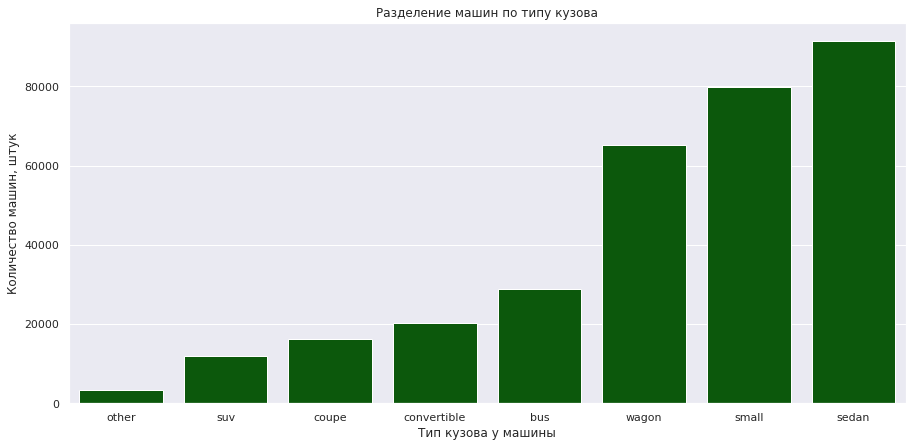

In [9]:
# что с типом кузова?
sns.set(rc={'figure.figsize': (15, 7)})
ax = sns.barplot(data=autos.groupby(by='VehicleType', as_index=False).RegistrationYear.count().sort_values(by='RegistrationYear'),\
                 x='VehicleType', y='RegistrationYear', color='darkgreen')
ax.set(title='Разделение машин по типу кузова', xlabel='Тип кузова у машины', ylabel='Количество машин, штук')
plt.show()

У нас 8 разных типов кузова у машин. Самый распостранённый - седан (примерно 90 тысяч штук), затем маленькие машины (примерно 80 тысяч штук), затем тип wagon (вагоны!?) - их примерно 62 - 63 тысячи штук. Остальные типы кузова не так распостранены. Поскольку у нас нет самих фотографий и какой - либо программы для определения типа кузова, мы можем только создать свою категорию - Неизвестно (unknown). Единственный минус - эта категория будет достаточно многочисленна и будет занимать 4ую место по популярности, но лучше варианта предложить сложно - любое добавление в текущие категории может оказаться не точным.

In [10]:
# заполняем пропуски в столбце VehicleType
autos.VehicleType.fillna('unknown', inplace=True)

Пропуски в столбце модель как - то осмысленно заполнить сложно: для этого надо иметь знатока различных автомобильных фирм рядом и фотографии машины как минимум и то не факт, что всё правильно заполнит. Можно сделать проще - заменить пропуски на неизвестный например.

А вот посмотреть как распределены коробки передач можно, особенно в связи с годом выхода машины. Вполне может быть взаимосвязь.

In [11]:
# заполняем пропуски в столбце Model
autos.Model.fillna('unknown', inplace=True)

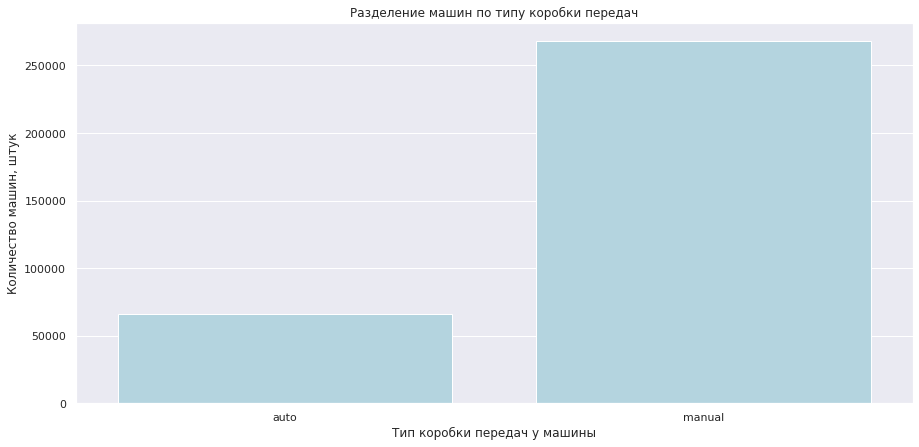

In [12]:
# смотрим что с распределением коробок передач в автомобиле
ax = sns.barplot(data=autos.groupby(by='Gearbox', as_index=False).RegistrationYear.count().sort_values(by='RegistrationYear'),\
                 x='Gearbox', y='RegistrationYear', color='lightblue')
ax.set(title='Разделение машин по типу коробки передач', xlabel='Тип коробки передач у машины', ylabel='Количество машин, штук');

Ручные коробки передач у машин встречаются более чем в 4 раза чаще, чем автоматические. А Если посмотреть на ситуацию с учётом года выхода машины? Может будет лучше прослеживаться какая-либо тенденция!?

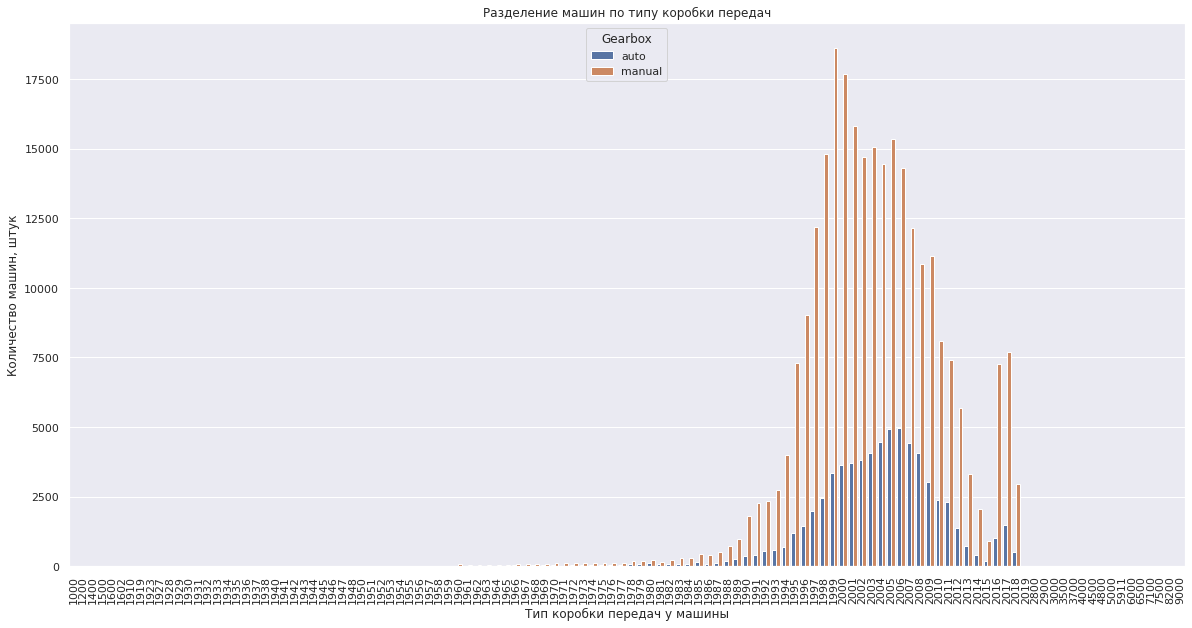

In [13]:
# типы коробки передач с учётом выхода автомобиля
sns.set(rc={'figure.figsize': (20, 10)})
ax = sns.barplot(data=autos.groupby(by=['Gearbox', 'RegistrationYear'], as_index=False).Brand.count().sort_values(by='RegistrationYear'),\
                 x='RegistrationYear', y='Brand', hue='Gearbox')
ax.set(title='Разделение машин по типу коробки передач', xlabel='Тип коробки передач у машины', ylabel='Количество машин, штук')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

К сожалению, нам не удалось выявить тенденцию. Хоть заполняй случайно (соблюдая пропорцию). А вот что мы увидели - это дефектные данные. Не может быть год регистрации машины раньше 1910 и больше даты выгрузки из базы. Такие данные надо удалить.

In [14]:
# удаляем дефектные данные, обнаруженные в столбце RegistrationYear
autos = autos.query('RegistrationYear >= 1910 & RegistrationYear <= DateCrawled.dt.year')

# сколько строк осталось?
print(autos.shape)

(339769, 16)


Данных потеряли прилично (более 4% или 14600 строк), а вот данные стали чище. Заполним пропуски в этом столбце (Gearbox) исходя из предведущих данных по совпадающей марке машины и году, а потом проверим всё ли заполнилось.

In [15]:
# заполняем пропуски в столбце Gearbox
autos["Gearbox"] = autos.groupby(['Brand', 'RegistrationYear'])["Gearbox"].transform(lambda x: x.ffill())
# если остались незаполенные значения - будет manual (наиболее распостранённое)
autos.Gearbox.fillna('manual', inplace=True)

# проверем уникальные значения столбца Gearbox и выводим общую информацию о датафрейме
print(autos.Gearbox.unique())
print(autos.info())

['manual' 'auto']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 339769 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339769 non-null  datetime64[ns]
 1   Price              339769 non-null  int64         
 2   VehicleType        339769 non-null  object        
 3   RegistrationYear   339769 non-null  int64         
 4   Gearbox            339769 non-null  object        
 5   Power              339769 non-null  int64         
 6   Model              339769 non-null  object        
 7   Kilometer          339769 non-null  int64         
 8   RegistrationMonth  339769 non-null  int64         
 9   FuelType           312520 non-null  object        
 10  Brand              339769 non-null  object        
 11  Repaired           339769 non-null  object        
 12  DateCreated        339769 non-null  datetime64[ns]
 13  NumberOfPictures   339769 

Осталось только заняться пропусками в столбце FuelType. Посмотрим, что там за данные.

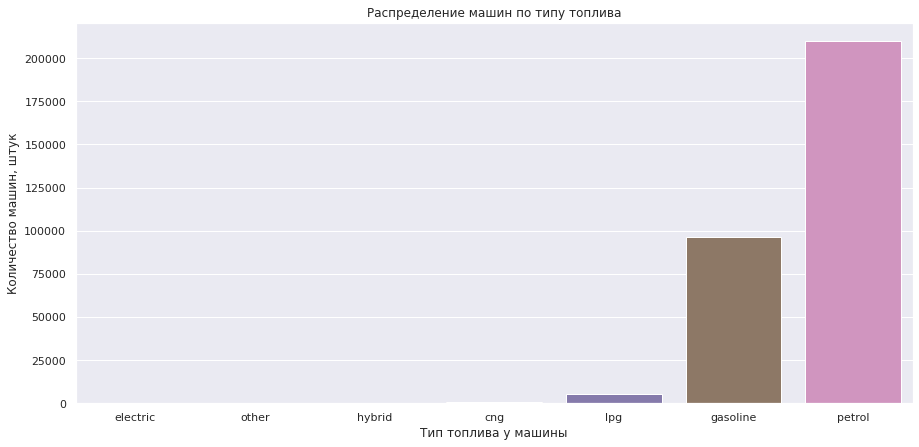

In [16]:
# изучаем распределение машин по типу топлива
sns.set(rc={'figure.figsize': (15, 7)})
ax = sns.barplot(data=autos.groupby(by=['FuelType'], as_index=False).Brand.count().sort_values(by='Brand'),\
                 x='FuelType', y='Brand')
ax.set(title='Распределение машин по типу топлива', xlabel='Тип топлива у машины', ylabel='Количество машин, штук');

Итак - самые рапостранённые варианты - бензин, горючее топливо и сжиженный нефтяной газ. Притом бензин встречается на порядок чаще остальных. Заполним пропуски на наиболее часто встречающиеся значение - petrol (бензин).

In [17]:
# незаполенные значения в столбце FuelType заполняем значением petrol
autos.FuelType.fillna('petrol', inplace=True)

In [18]:
# проверяем заполненность данных
print(autos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339769 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339769 non-null  datetime64[ns]
 1   Price              339769 non-null  int64         
 2   VehicleType        339769 non-null  object        
 3   RegistrationYear   339769 non-null  int64         
 4   Gearbox            339769 non-null  object        
 5   Power              339769 non-null  int64         
 6   Model              339769 non-null  object        
 7   Kilometer          339769 non-null  int64         
 8   RegistrationMonth  339769 non-null  int64         
 9   FuelType           339769 non-null  object        
 10  Brand              339769 non-null  object        
 11  Repaired           339769 non-null  object        
 12  DateCreated        339769 non-null  datetime64[ns]
 13  NumberOfPictures   339769 non-null  int64   

Теперь построим распределение всех числовых столбцов, чтобы понять с чем мы имеем дело.

count    339769.000000
mean       4471.332061
std        4546.037804
min           0.000000
5%          200.000000
25%        1099.000000
50%        2799.000000
75%        6500.000000
95%       14800.000000
max       20000.000000
Name: Price, dtype: float64


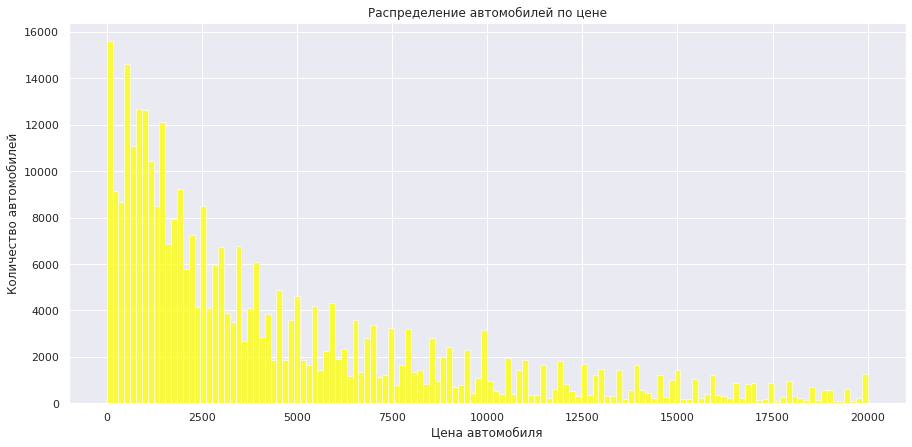

In [19]:
# исследование автомобилей по их цене
print(autos.Price.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
ax = sns.histplot(autos.Price, color='yellow')
ax.set(title='Распределение автомобилей по цене', xlabel='Цена автомобиля', \
       ylabel='Количество автомобилей');

Цены на машины сильно растянуты - до 20000 евро. А вот средняя цена - 4400 евро, да и медиана не далеко. Также отметим достаточно большое число машин без стоимости. Но машины с нулевой стоимостью это бред. Даже металлолом и то денег стоит. В связи с этим удалим машины, чья стоимость меньше 50 евро.

In [20]:
# удаляем машины, чья стоимость меньше 50 евро
autos = autos.query('Price >= 50')

# смотрим на то, сколько данных у нас осталось
print(autos.shape)

(328192, 16)


count    328192.000000
mean        112.135055
std         185.103679
min           0.000000
5%            0.000000
25%          71.000000
50%         105.000000
75%         143.000000
95%         218.000000
99.5%       334.000000
max       20000.000000
Name: Power, dtype: float64


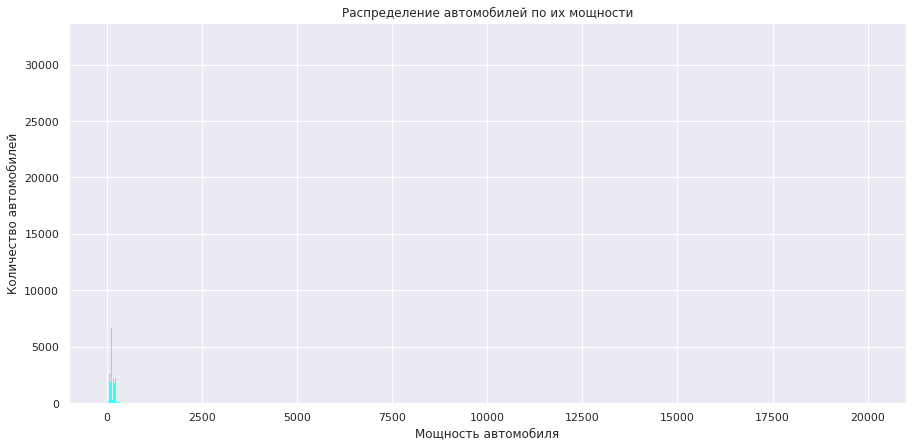

In [21]:
# исследование автомобилей по их мощности
print(autos.Power.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.995]))
ax = sns.histplot(autos.Power, color='cyan')
ax.set(title='Распределение автомобилей по их мощности', \
       xlabel='Мощность автомобиля', ylabel='Количество автомобилей');

Снова кривые данные! Мощность автомобиля не должна быть больше 350 л.с., иначе это уже не автомобиль, а ракета, не иначе и также надо удалить данные, где мощность менее 5 л.с. - где вы видели такие автомобили!?.

In [22]:
# удаляем машины с мощьюстью выше 350 л.с. и менее 5 л.с.
autos = autos.query('Power <= 350 & Power >= 5')

(294959, 16)


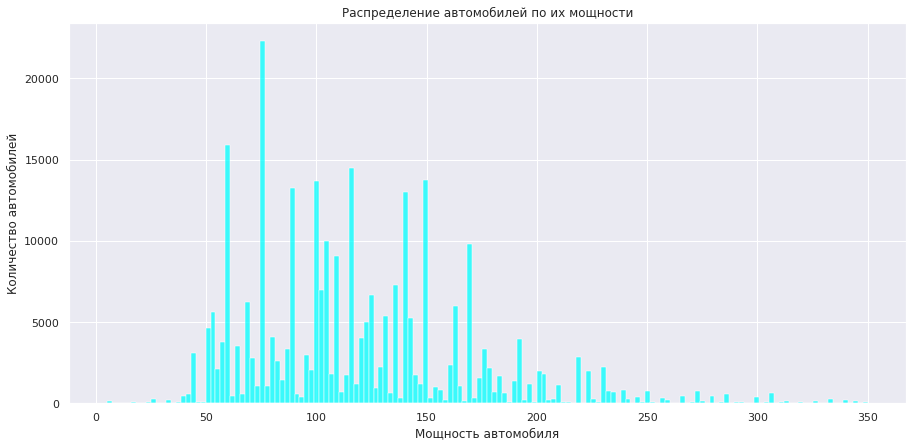

In [23]:
# смотрим на остатки данных
print(autos.shape)

# строим новый график для наглядности мощности автомобилей
ax = sns.histplot(autos.Power, color='cyan')
ax.set(title='Распределение автомобилей по их мощности', \
       xlabel='Мощность автомобиля', ylabel='Количество автомобилей');

От кривых данных по мощности автомобилей избавились. Теперь посмотрим, что с километражом, который проехала каждая машина. Единственный момент, который не нравиться - количество этих самых кривых данных - мы уже удалили немногим менее 17% от первоначальных данных.

count    294959.000000
mean     128266.420079
std       36759.769309
min        5000.000000
5%        40000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
95%      150000.000000
99.5%    150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


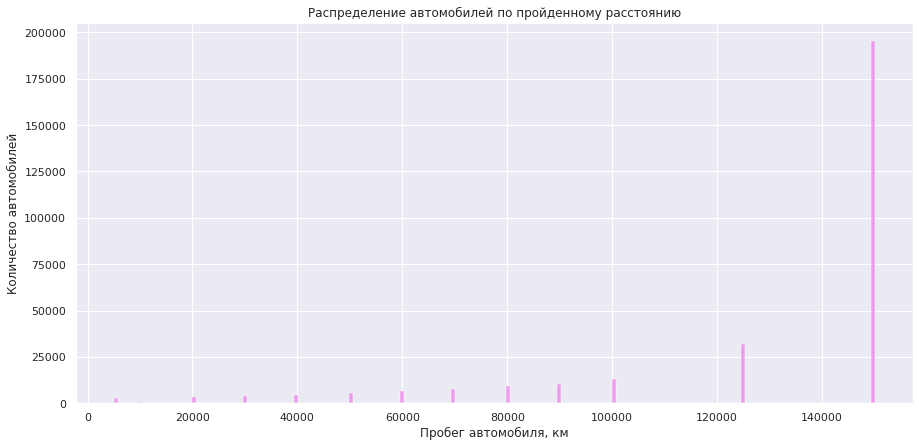

In [24]:
# исследование машин по километражу проеханному
ax = sns.histplot(autos.Kilometer, color='violet')
ax.set(title='Распределение автомобилей по пройденному расстоянию', \
       xlabel='Пробег автомобиля, км', ylabel='Количество автомобилей')
print(autos.Kilometer.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.995]))

Неожиданно! Похоже, весь пробег автомобилей очень сильно округляли. В любом случае в основном ожидается или пробег в 125000 или в 150000 километров. Остальное встречается намного реже.

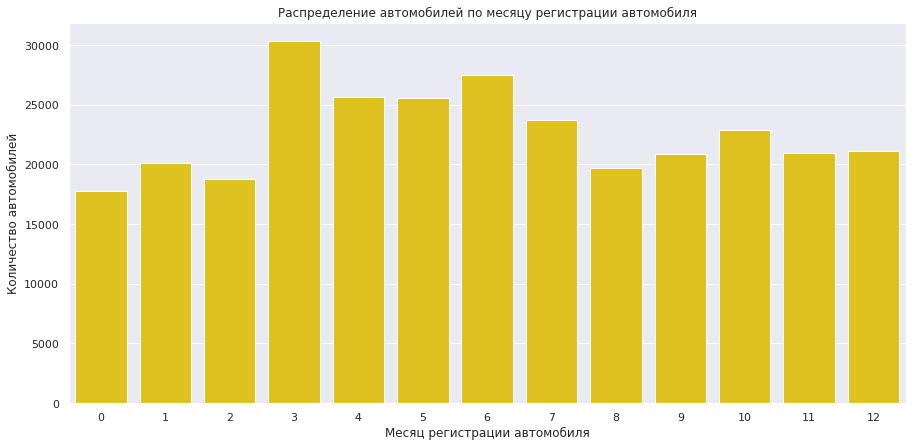

In [25]:
# исследование по столбцу месяц регистрации (RegistrationMonth)
ax = sns.barplot(data=autos.groupby('RegistrationMonth', as_index=False).Brand.count(),\
                 x='RegistrationMonth', y='Brand', color='gold')
ax.set(title='Распределение автомобилей по месяцу регистрации автомобиля', \
       xlabel='Месяц регистрации автомобиля', ylabel='Количество автомобилей');

Ещё одна несостыковка: а именно - в году 12 месяцев, а не 13! Можно только предположить, что месяцы с 1 по 12 - это двенадцать месяцев года, а месяц 0 - это для тех машин в котором неизвестно в каком месяце была регистрация. Но уверенности в этом нет никакой. Пока что можно сказать, что два самых полулярных месяца для регистрации автомобиля - это месяца за номерами - 3 и 6, далее следуют месяца 4 и 5. В любом случае этот признак рассматривать для построении моделей не стоит - на стоимость он не должен влиять.

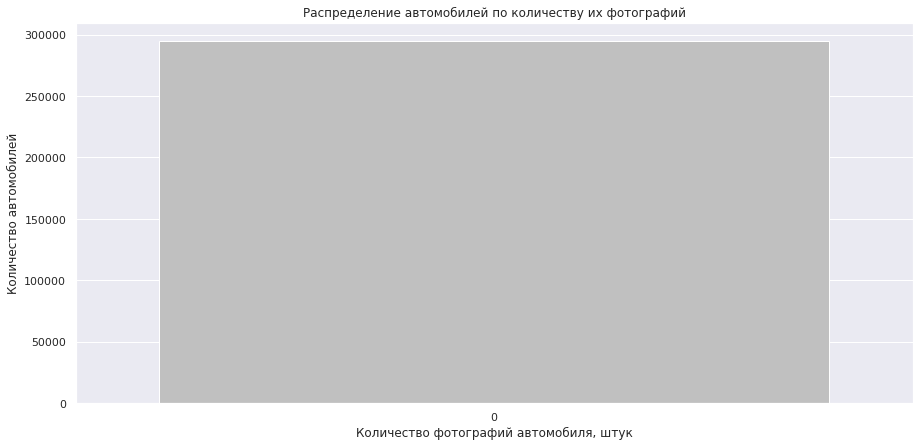

In [26]:
# исследуем столбец с количеством фотографий машины (NumberOfPictures)
ax = sns.barplot(data=autos.groupby('NumberOfPictures', as_index=False).Brand.count(),\
                 x='NumberOfPictures', y='Brand', color='silver')
ax.set(title='Распределение автомобилей по количеству их фотографий', \
       xlabel='Количество фотографий автомобиля, штук', ylabel='Количество автомобилей');

Это либо плохая шутка, либо сбой в программе. Притом, скорее второе. В таком виде пользы от этого столбца для анализа нет.

В любом случае пора исключать из анализа бесполезные столбцы. Далее перевести все оставшиеся столбцы к численному виду. И наконец, делить выборку на признаки и цель, а также на обучающую и тестовую выборки.

In [27]:
# исключаем из анализа бесполезные столбцы
autos_clean = autos.drop(['DateCrawled', 'RegistrationMonth', \
                          'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [28]:
# столбец Kilometer приводим к типу object - он дискретный и по сути является категорией, а не значением
autos_clean['Kilometer'] = autos_clean['Kilometer'].astype('object')

Сначала разделим данные, а потом преобразуем их по типу OrdinalEncoder. После этого мы будем готовы обучать модели

In [29]:
# делим данные на цель и признаки
features_auto = autos_clean.drop('Price', axis=1)
target_auto = autos_clean.Price

# делим выборку на обучающую и тестовую 
features_auto_train, features_auto_test, target_auto_train, target_auto_test = train_test_split(features_auto, target_auto, \
                                                                                               test_size=0.25, random_state=123)
# делаем копии для второго кодирования для линейных моделей
features_auto_train_ohe = features_auto_train.copy()
features_auto_test_ohe = features_auto_test.copy()

# сколько данных в обучающей выборке и в тесте?
print(features_auto_train.shape, target_auto_train.shape)
print(features_auto_test.shape, target_auto_test.shape)

(221219, 9) (221219,)
(73740, 9) (73740,)


In [30]:
# перебираем все сбившиеся индексы
features_auto.reset_index(drop=True, inplace=True)
features_auto_train.reset_index(drop=True, inplace=True)
features_auto_test.reset_index(drop=True, inplace=True)
target_auto.reset_index(drop=True, inplace=True)
target_auto_train.reset_index(drop=True, inplace=True)
target_auto_test.reset_index(drop=True, inplace=True)
features_auto_train_ohe.reset_index(drop=True, inplace=True)
features_auto_test_ohe.reset_index(drop=True, inplace=True)

In [31]:
# кодируем столбцы по типу OrdinalEncoder
categories = ['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']
encoder = OrdinalEncoder(dtype='uint32')
encoder.fit(features_auto_train[categories])

OrdinalEncoder(dtype='uint32')

In [32]:
features_auto_train.loc[:, categories] = pd.DataFrame(encoder.transform(features_auto_train[categories]), \
                                   columns=categories)
features_auto_test.loc[:, categories] = pd.DataFrame(encoder.transform(features_auto_test[categories]), \
                                  columns=categories)
features_auto.loc[:, categories] = pd.DataFrame(encoder.transform(features_auto[categories]), \
                                  columns=categories)

# проверяем типы данных в признаках обучающей и тестовой модели
print(features_auto_train.info())
print(features_auto_test.info())

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221219 entries, 0 to 221218
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       221219 non-null  uint32
 1   RegistrationYear  221219 non-null  int64 
 2   Gearbox           221219 non-null  uint32
 3   Power             221219 non-null  int64 
 4   Model             221219 non-null  uint32
 5   Kilometer         221219 non-null  uint32
 6   FuelType          221219 non-null  uint32
 7   Brand             221219 non-null  uint32
 8   Repaired          221219 non-null  uint32
dtypes: int64(2), uint32(7)
memory usage: 9.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73740 entries, 0 to 73739
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   VehicleType       73740 non-null  uint32
 1   RegistrationYear  73740 non-null  int64 
 2   Gearbox           7374

In [33]:
# октроем признаки и увидим новые таблицы
display(features_auto_train.head(10))
display(features_auto_test.head(10))

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,4,2013,1,99,119,5,6,12,0
1,4,2005,1,109,57,11,2,5,0
2,0,2004,1,136,103,12,2,10,0
3,2,1999,1,170,11,12,6,2,1
4,8,1998,1,90,17,12,6,19,0
5,4,1989,1,115,22,12,6,1,1
6,5,1996,1,75,173,12,6,38,0
7,8,2003,1,107,10,12,2,25,0
8,0,2011,1,170,38,12,2,30,0
9,8,2000,1,116,227,12,6,10,0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,5,2010,1,98,165,7,6,21,0
1,5,2000,1,80,247,12,6,17,0
2,4,1998,1,55,176,2,6,9,0
3,4,2005,1,98,37,11,6,23,0
4,8,2005,1,115,163,12,6,31,0
5,4,2005,1,272,116,12,6,38,0
6,8,2002,1,130,154,12,2,10,0
7,4,1998,1,101,170,12,6,38,0
8,4,2000,1,204,116,12,6,38,0
9,5,1999,1,56,227,12,6,24,1


In [34]:
# кодируем данные по типу OHE
features_auto_train_ohe = pd.get_dummies(data=features_auto_train_ohe, drop_first=True, columns=categories, dtype='uint32')
features_auto_test_ohe = pd.get_dummies(data=features_auto_test_ohe, drop_first=True, columns=categories, dtype='uint32')

# проверяем размер для проверки
print(features_auto_train_ohe.shape)
print(features_auto_test_ohe.shape)

(221219, 318)
(73740, 315)


Бывает и такое, что какие-то признаки встречаются только в обучающем или тестовом датафрейме. Но даже в случае равенства признаков надо проверять их всех поимённо. Лишние (не встречающиеся в тесте/ обучающей выборке надо удалить. Для такого поиска напишем функцию.

In [35]:
# функция для поиска лишних столбцов в тесте и в трейне
def search_extra_columns(df_train, df_test):
    columns_train = df_train.columns
    columns_test = df_test.columns
    lst_drop_train, lst_drop_test = [], []
    for i in range(len(columns_train)):
        if columns_train[i] not in columns_test:
            lst_drop_train.append(columns_train[i])
    for i in range(len(columns_test)):
        if columns_test[i] not in columns_train:
            lst_drop_test.append(columns_test[i])
    return (lst_drop_train, lst_drop_test)

# применяем функцию для поиска лишних столбцов в выборках
drop_train, drop_test = search_extra_columns(features_auto_train_ohe, features_auto_test_ohe)
# удаляем лишние столбцы
features_auto_train_ohe.drop(drop_train, axis=1, inplace=True)
features_auto_test_ohe.drop(drop_test, axis=1, inplace=True)
# проверяем форму теперь
print(features_auto_train_ohe.shape)
print(features_auto_test_ohe.shape)

(221219, 315)
(73740, 315)


Теперь мы готовы обучать динейные модели.

Всё в порядке, хотя данные выглядят и так довольно объёмными. В любом случае мы  избавились от повторов, от дефектных данных и от бесполезных столбцов. Пора обучать модели. Но  сначала стоит проверить (на всякий случай) корреляцию наших признаков общей матрице признаков.

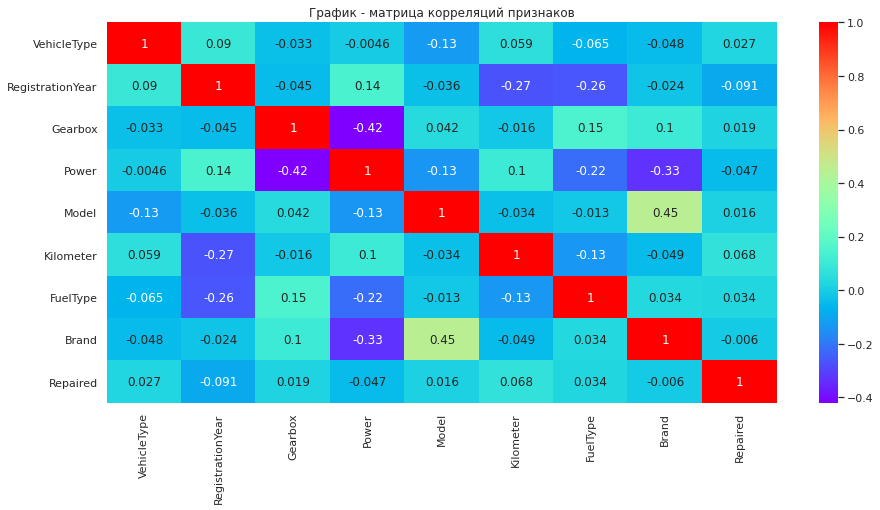

In [36]:
# строим график корреляции на общей выборке
ax = sns.heatmap(data=features_auto.corr(), annot=True, cmap='rainbow')
ax.set(title='График - матрица корреляций признаков');

Теперь мы точно уверены, что признаки не очень сильно вляют друг на друга. Пора обучать модели!

## Обучение моделей

Обучим 3 обычных модели: Гребневую регрессию, Решающее дерево и Случайный лес, а также модель с градиентным бустингом. Для обычных моделей Решающего дерева и Случайного леса будем использовать кросс - валидацию для уменьшения переобучения.

In [37]:
start_ridge = time()
# поиск оптимальных параметров гребневой регрессии с кросс - валидацией
model_ridge = RidgeCV(alphas=(0.1, 1.0, 5.0, 10.0), scoring='neg_root_mean_squared_error', cv=5)
model_ridge.fit(features_auto_train_ohe, target_auto_train)
end_ridge = time()
model_time_ridge = (end_ridge - start_ridge) / 60 # время поиска оптимальных параметров гребневой регрессии в минутах
print('Время поика оптимальных параметров гребневой регрессии:', model_time_ridge)

Время поика оптимальных параметров гребневой регрессии: 0.8663651386896769


In [38]:
# выводим оценку гребневой регрессии
best_score_ridge = -model_ridge.best_score_.round(2)
alpha = model_ridge.alpha_
print('RMSE гребневой регрессии равна:', best_score_ridge)
print('Параметр альфа для гребневой регрессии равен:', alpha)

RMSE гребневой регрессии равна: 2531.15
Параметр альфа для гребневой регрессии равен: 1.0


In [39]:
# обучаем гребневую регрессию
start_ridge = time()
model_ridge = Ridge(alpha=alpha, random_state=123)
model_ridge.fit(features_auto_train_ohe, target_auto_train)
end_ridge = time()
time_train_ridge = (end_ridge - start_ridge) / 60 # время обучения гребневой регрессии в минутах
print('Время обучения гребневой регрессии в минутах:', time_train_ridge)

Время обучения гребневой регрессии в минутах: 0.03666228453318278


In [40]:
# измеряем время предсказания гребневой регрессии
start_pred_ridge = time()
model_ridge.predict(features_auto_train_ohe)
end_pred_ridge = time()
time_pred_ridge = (end_pred_ridge - start_pred_ridge) / 60 # время предсказания гребневой регрессии в минутах
print('Время предсказания гребневой регрессии в минутах:', time_pred_ridge)

Время предсказания гребневой регрессии в минутах: 0.014928015073140462


Обучение гребневой регрессии с кросс - валидацией очень быстрое, но качество оценки скорее всего далеко не лучшее...

In [41]:
%%time

# обучаем решающее дерево с кросс - валидацией
param_grid_tree = {'max_depth': range(2, 21, 2), 'min_samples_split': range(2, 23, 2), \
                   'min_impurity_decrease': np.arange(0.0, 0.05, 0.01)}
model_tree = DecisionTreeRegressor(random_state=123)
gsearch_tree = GridSearchCV(estimator=model_tree, cv=3, param_grid=param_grid_tree,\
                            scoring ='neg_root_mean_squared_error')

CPU times: user 0 ns, sys: 234 µs, total: 234 µs
Wall time: 114 µs


In [42]:
start_tree = time()

gsearch_tree.fit(features_auto_train, target_auto_train)
best_model_tree = gsearch_tree.best_estimator_
best_score_tree = gsearch_tree.best_score_
params_tree = gsearch_tree.best_params_
end_tree = time()
model_time_tree = (end_tree - start_tree) / 60 # время обучения дерева в минутах
print(f'Оценка дерева с кросс - валидацией: {-best_score_tree.round(2)}', \
      f'Параметры дерева с кросс - валидацией: {params_tree}', \
      f'Время поиска и обучения решающего дерева: {model_time_tree}', sep='\n')

Оценка дерева с кросс - валидацией: 1794.73
Параметры дерева с кросс - валидацией: {'max_depth': 18, 'min_impurity_decrease': 0.01, 'min_samples_split': 22}
Время поиска и обучения решающего дерева: 6.7060725013415015


In [43]:
# измеряем время обучения модели дерева
start_train_tree = time()
best_model_tree.fit(features_auto_train, target_auto_train)
end_train_tree = time()
time_train_tree = (end_train_tree - start_train_tree) / 60 # время обучения дерева в минутах
print('Чистое время обучения дерева (без поиска гиперпараметров):', time_train_tree)

Чистое время обучения дерева (без поиска гиперпараметров): 0.008246962229410808


In [44]:
start_pred_tree = time()
# измеряем скорость предсказаний
pred_tree_train = best_model_tree.predict(features_auto_train)
end_pred_tree = time()
time_pred_tree = (end_pred_tree - start_pred_tree) / 60 # время предсказания дерева в минутах
print('Время предсказаний дерева:', time_pred_tree)

Время предсказаний дерева: 0.0007678866386413574


Учит модель дерева не очень долго. Точность у неё заметно выше, чем у гребневой регрессии (1795 против 2531). Гиперпараметры дерева почти максимально возможные - max_depth - 18, min_samples_split - 22 и min_impurity_decrease - 0.01. Скорость предсказаний - быстрая.

Но что будет на тесте...

In [45]:
start_forest = time()

# обучаем случайный лес
param_grid_forest = {'n_estimators': range(50, 151, 20), 'max_depth': range(3, 22, 2)}
model_forest = RandomForestRegressor(criterion='friedman_mse' ,random_state=123)
gsearch_forest = GridSearchCV(estimator=model_forest, cv=3, param_grid=param_grid_forest,\
                            scoring = 'neg_root_mean_squared_error')
gsearch_forest.fit(features_auto_train, target_auto_train)
best_model_forest = gsearch_forest.best_estimator_
best_score_forest = gsearch_forest.best_score_
params_forest = gsearch_forest.best_params_
end_forest = time()
time_model_forest = (end_forest - start_forest) / 60 # время обучения модели случайного леса
print(f'Оценка случайного леса с кросс - валидацией: {-best_score_forest.round(2)}', \
      f'Параметры случайного леса с кросс - валидацией: {params_forest}', \
      f'Время поиска гиперпараметров и обучения модели леса: {time_model_forest}', sep='\n')     

Оценка случайного леса с кросс - валидацией: 1588.57
Параметры случайного леса с кросс - валидацией: {'max_depth': 19, 'n_estimators': 150}
Время поиска гиперпараметров и обучения модели леса: 53.194153281052905


Лес с кросс - валидацией учиться долго! Больше часа! Это много по сравнению с другими моделями. Качество ожидаемо выше по сравнению с решающим деревом (1589 против 1795). Но стоит ли улучшение потраченного времени? Параметры леса: 'max_depth': 19, 'n_estimators': 150, criterion='friedman_mse'. Осталось понять как долго он делает предсказания и посмотреть на модель градиентного бустинга.

In [46]:
# измеряем время обучения модели случайного леса
start_train_forest = time()
best_model_forest.fit(features_auto_train, target_auto_train)
end_train_forest = time()
time_train_forest = (end_train_forest - start_train_forest) / 60 # время обучения дерева в минутах
print('Чистое время обучения случайного леса (без поиска гиперпараметров):', time_train_forest)

Чистое время обучения случайного леса (без поиска гиперпараметров): 0.9063564459482829


Даже время обучения около 2 минут! Долго, однако.

In [47]:
start_pred_forest = time()

# Измеряем время предсказания случайного леса
pred_forest_train = best_model_forest.predict(features_auto_train)
end_pred_forest = time()
time_pred_forest = (end_pred_forest - start_pred_forest) / 60 # время пресказаний леса в минутах
print('Время предсказаний у случайного леса:', time_pred_forest)

Время предсказаний у случайного леса: 0.12154570817947388


Предсказания по времени относительно долгие! Примерно 8.5 секунд. Что же сможет показать модель градиентного бустинга?

In [48]:
%%time

# ставим параметры модели градиентного бустинга
model_lgb = lgb.LGBMRegressor(objective="regression",random_state=123)
gsearch_lgb = GridSearchCV(estimator=model_lgb, cv=3, param_grid={'num_iterations': range(140, 201, 30), \
                                                                  'learning_rate': np.arange(0.1, 0.21, 0.05),\
                                                                  'num_leaves': [31, 63, 127, 255]},\
                           scoring ='neg_root_mean_squared_error')

CPU times: user 103 µs, sys: 1e+03 ns, total: 104 µs
Wall time: 108 µs


In [49]:
# обучаем модель градиентного бустинга
start_model_lgb = time()
gsearch_lgb.fit(features_auto_train, target_auto_train)
best_model_lgb = gsearch_lgb.best_estimator_
best_score_lgb = gsearch_lgb.best_score_
params_lgb = gsearch_lgb.best_params_
end_model_lgb = time()
time_model_lgb = (end_model_lgb - start_model_lgb) / 60 # время обучения модели градиентного бустинга
print(f'Оценка градиентного бустинга с кросс - валидацией: {-best_score_lgb.round(2)}', \
      f'Параметры градиентного бустинга с кросс - валидацией: {params_lgb}', \
      f'Время обучения градиентного бустинга с кросс - валидацией: {time_model_lgb}', sep='\n')

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Оценка градиентного бустинга с кросс - валидацией: 1525.95
Параметры градиентного бустинга с кросс - валидацией: {'learning_rate': 0.1, 'num_iterations': 200, 'num_leaves': 255}
Время обучения градиентного бустинга с кросс - валидацией: 21.287200061480203


Качество модели градиентного бустинга с кросс - валидацией оказалось даже выше модели случайного леса (1526 против 1588), а вот скорость обучения намного - 4.5 минуты! Параметры градиентного бустинга модели LGBMRegressor - 'learning_rate': 0.1, 'num_iterations': 200, 'num_leaves'= 255

In [50]:
# измеряем время обучения модели градиентного бустинга
start_train_lgb = time()
best_model_lgb.fit(features_auto_train, target_auto_train)
end_train_lgb = time()
time_train_lgb = (end_train_lgb - start_train_lgb) / 60 # время обучения дерева в минутах
print('Чистое время обучения градиентного бустинга (без поиска гиперпараметров):', time_train_lgb)

Чистое время обучения градиентного бустинга (без поиска гиперпараметров): 0.4115392009417216


In [51]:
# измеряем время предсказаний градиентного спуска
start_pred_lgb = time()
pred_lgb_train = best_model_lgb.predict(features_auto_train)
end_pred_lgb = time()
time_pred_lgb = (end_pred_lgb - start_pred_lgb) / 60 # время пресказаний леса в минутах
print('Время предсказаний у градиентного бустинга:', time_pred_lgb)

Время предсказаний у градиентного бустинга: 0.0968030571937561


Скорость предсказаний неплоха (сравнима с решающим деревом и значительно быстрее, чем случайный лес). Точность тоже в норме.

## Анализ моделей

Для наглядности сделаем небольшой датафрейм с названием модели, временем обучения, точностью прогнозов по RMSE и скоростью предсказаний.

In [52]:
# делаем датафрейм для наглядности
data_model = [['Ridge', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor'], \
              [time_train_ridge, time_train_tree, time_train_forest, time_train_lgb], \
              [best_score_ridge, -best_score_tree, -best_score_forest, -best_score_lgb], \
              [time_pred_ridge, time_pred_tree, time_pred_forest, time_pred_lgb]]
data_model = pd.DataFrame(data=data_model, index=['name_model', 'time_train', 'rmse', 'time_pred'])
display(data_model)

,0,1,2,3
name_model,Ridge,DecisionTreeRegressor,RandomForestRegressor,LGBMRegressor
time_train,0.036662,0.008247,0.906356,0.411539
rmse,2531.15,1794.732824,1588.570028,1525.946725
time_pred,0.014928,0.000768,0.121546,0.096803


Все модели быстры и проворны в обучении и предсказании, кроме модели Случайного леса. Она и долго обучается (в разы дольше всех) и медленнее всех даёт результаты, но это уже не так критично (8-9 секунд найдут почти все). По возрастанию точности прогноза порядок такой: гребневая регрессия, решающее дерево, случайный лес, и наконец, самый точный - градиентный бустинг.

В таких условиях, конечно, надо выбирать градиентный бустинг и смотреть его предсказания на тестовой выборке.

In [53]:
%%time

# модель градиентного бустинга на тестовой выборке
pred_lgb_test = best_model_lgb.predict(features_auto_test)
print('RMSE градиентного бустинга на тестовой выборке' ,mean_squared_error(target_auto_test, pred_lgb_test,\
                                                                           squared=False).round(2))

RMSE градиентного бустинга на тестовой выборке 1505.45
CPU times: user 2 s, sys: 736 µs, total: 2 s
Wall time: 1.94 s


Быстрые и достаточно точные результаты (даже немного превосходя результат обучения с кросс - валидацией) даёт нам модель градиентного спуска. Но в любом случае надо проверить нашу модель со стандартной - на вменяемость.

In [54]:
# проверка - сравнение с моделью DummyRegressor
model_dummy = DummyRegressor(strategy='mean')
model_dummy.fit(features_auto_train, target_auto_train)
pred_dummy = model_dummy.predict(features_auto_test)
print('RMSE константной модели на тестовой выборке' , mean_squared_error(target_auto_test, pred_dummy, squared=False).round(2))

RMSE константной модели на тестовой выборке 4582.28


Успех! Наша модель градиентного бустинга в разы лучше константной модели, что означет что она адекватна.

## Вывод

По итогу обучения всех моделей можно сделать вывод о том что по соотношению скорость обучения/скорость прогнозов/точность результата однозначно лидирует модель градиентного бустинга с параметрами 'num_iterations': 200, 'num_leaves': 255, 'learning_rate': 0.1. Сравниться по точности с нашей моделью может лишь модель случайного леса, но она значительно дольше обучается и также значительно дольше делает прогнозы.